In [192]:
from dataset import IAM, Encoder
from dataloader import CTCDataLoader
from model import CRNNModel
from deslant import deslant

from torch.utils.data import DataLoader
import albumentations as A
from sklearn import preprocessing
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import Compose, ToTensor, Resize
import cv2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
dataset = IAM('/mnt/d/Machine-Learning/Datasets/iamdataset/uncompressed', csv_file_path='iam_df.csv')

In [3]:
print("Size of Dataset:", len(dataset))
print("Character set:", dataset.charset)
print("Vocab size:", len(dataset.charset))
dataset.data.head(10)

Size of Dataset: 13353
Character set:  !"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
Vocab size: 79


,Image,Segmentation,Transcription,Threshold
0,a01-000u-00.png,ok,A MOVE to stop Mr. Gaitskell from,154
1,a01-000u-01.png,ok,nominating any more Labour life Peers,156
2,a01-000u-02.png,ok,is to be made at a meeting of Labour,157
3,a01-000u-03.png,err,M Ps tomorrow. Mr. Michael Foot has,156
4,a01-000u-04.png,ok,put down a resolution on the subject,157
5,a01-000u-05.png,err,and he is to be backed by Mr. Will,156
6,a01-000u-06.png,ok,"Griffiths, M P for Manchester Exchange.",159
7,a01-000x-00.png,ok,A MOVE to stop Mr. Gaitskell from nominating,182
8,a01-000x-01.png,ok,any more Labour life Peers is to be made at a,181
9,a01-000x-02.png,ok,meeting of Labour 0M Ps tomorrow. Mr. Michael,181


In [3]:
encoder = Encoder()
data_loader = CTCDataLoader(dataset, encoder)
train_loader, val_loader, test_loader = data_loader(split=(0.6, 0.2, 0.2), batch_size=(32, 16, 16))

Calculate Loss: <br>
    1. Permute the tensor to bring the time_steps at first axis, i.e, from batch_size X time_steps X features to time_steps X batch X features <br>
        1.i.`out = out.permute(1, 0, 2)`<br>
    2. Perform log_softmax on feature axis on of the output tensor (ex: -1)<br>
        2.i. `out = F.log_softmax(out, dim=2) `<br>
    3. Specify length of inputs<br>
        3.i. `input_lengths = torch.full(size=(out.shape[1]), fill_value=out.shape[0], dtype=torch.int32)`<br>
    4. Specify the length of outputs (target) <br>
    5. Calculate loss
        5.i. `loss = nn.CTCLoss(blank=0, out, input_lengths, target_lengts)`


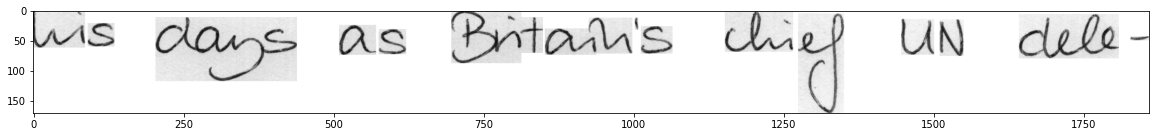

In [88]:
path = 'images/a02-012/a02-012-04.png'
img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(20, 10))
plt.imshow(img, cmap='gray')

array([ 71,  74,  75,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,
        87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,
       100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
       113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
       126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
       139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151,
       152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164,
       165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177,
       178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190,
       191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203,
       204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
       217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229,
       230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242,
       243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 25

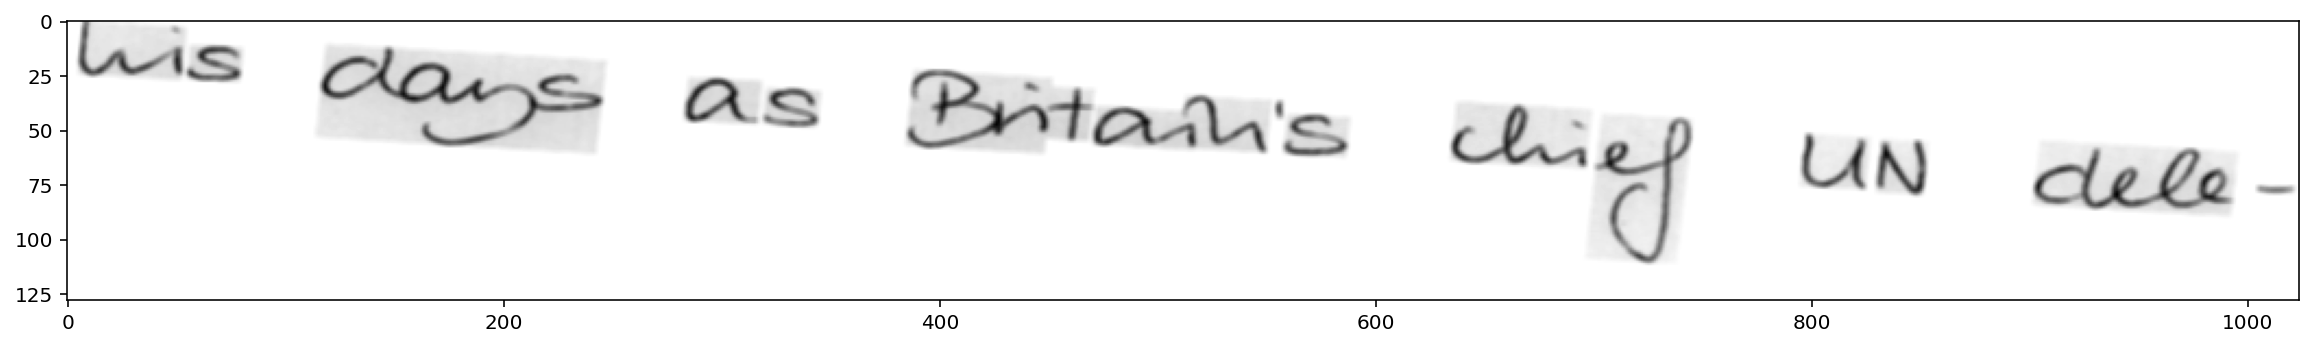

In [242]:

# Binarize the image
_,binary_image = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Affine Transform
affine_transform = A.augmentations.geometric.transforms.Affine(fit_output=True, shear=(-5, 5), rotate=None, cval=255, p=1.0)
# affine_image = affine_transform(image=binary_image)['image']

albu = A.Compose([
    A.augmentations.geometric.transforms.Affine(fit_output=True, shear=(-5, 5), cval=255, p=1.0),
    A.augmentations.geometric.Resize(height=128, width=1024, always_apply=True),
    A.augmentations.transforms.Blur(blur_limit=(3, 4), always_apply=True),
    A.augmentations.transforms.GaussNoise(always_apply=True)
])
albumented_image = albu(image=img)['image']

# f, axes = plt.subplots(4, 1, figsize=(20, 10))

# # we use `axes.ravel()` to turn these into a list
# axes = axes.ravel()

# for ax in axes:
#     ax.axis('off') # switch off the axis (lose the x and y axis tick marks on the edges)

# axes[0].imshow(affine_image1)

# axes[1].imshow(affine_image2)

# axes[2].imshow(affine_image3)

# axes[3].imshow(affine_image4)


# Resize
# resized_image = cv2.resize(np.array(affine_image, dtype=np.float32), (1024, 128), interpolation=cv2.INTER_AREA)

plt.figure(figsize=(20, 10))
plt.imshow(albumented_image, cmap='gray')
np.unique(albumented_image)


(128, 1024)

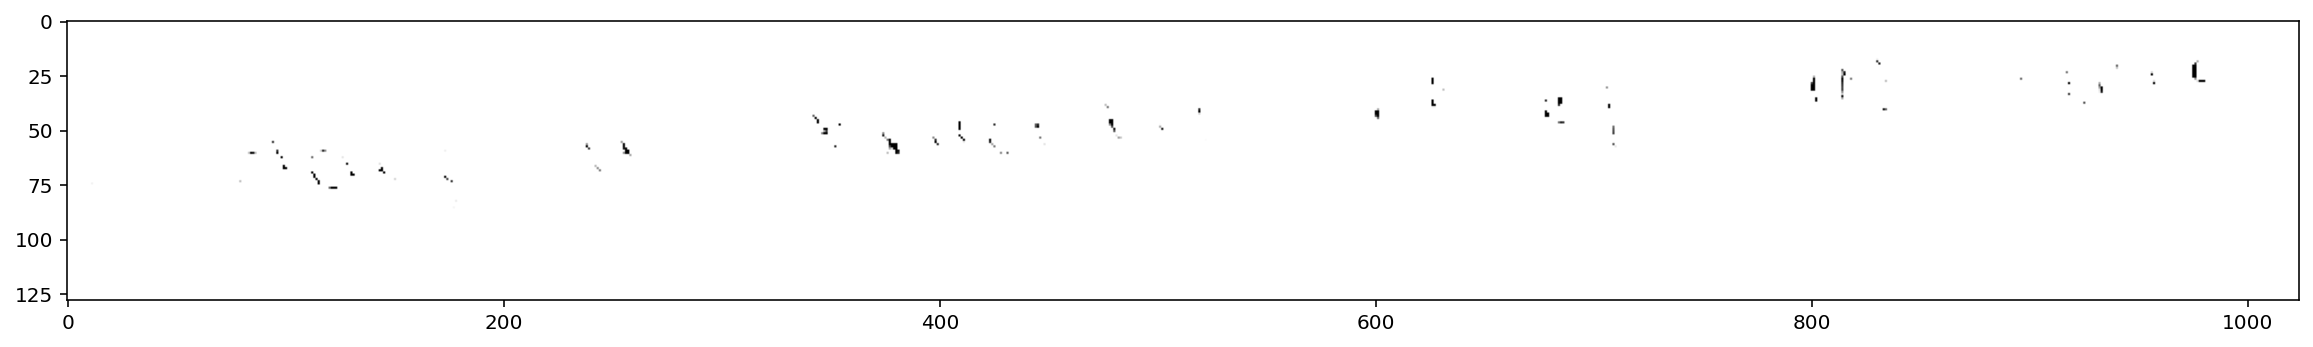

In [230]:
# Piecewise Affine Transform
elastic_transform = A.augmentations.geometric.transforms.PiecewiseAffine(always_apply=True, nb_rows=2, nb_cols=2)
elastic_image = elastic_transform(image=resized_image)['image']

plt.figure(figsize=(20, 10))
plt.imshow(elastic_image, cmap='gray')
elastic_image.shape

In [28]:
image = deslant(img, bg_color=255).img
# # Binarize
# image = (image > int(self.data.at[index, 'Threshold'])) * 1

# Otsu's thresholding
_,image = cv2.threshold(image,0,1,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Resize
image = cv2.resize(np.array(image, dtype=np.float32), (1024, 128),
                    interpolation=cv2.INTER_AREA)
# Rotate
image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)

transforms = Compose([
    ToTensor(),
])
image = transforms(image)
image = torch.unsqueeze(image, dim=0)


["so conrager os Engincening ance managemar'"]


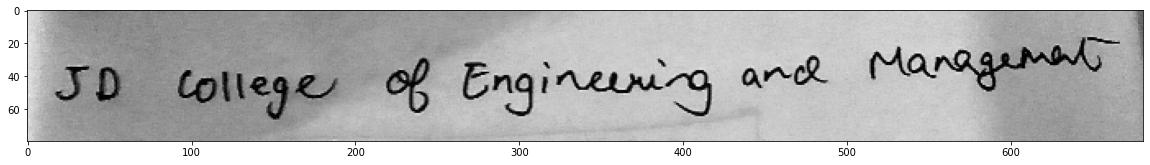

In [33]:

model = CRNNModel(vocab_size=79, time_steps=100)
device = 'cpu'
checkpoint = torch.load(
    'checkpoints/training_state.pth', map_location=device)
model.load_state_dict(checkpoint['model_state'])
model.eval()
pred = model(transformed_image)
plt.figure(figsize=(20, 10))
plt.imshow(img, cmap='gray')
print(encoder.best_path_decode(pred, True))

In [37]:
dataset.data.head()

,Image,Segmentation,Transcription,Threshold
0,a01-000u-00.png,ok,A MOVE to stop Mr. Gaitskell from,154
1,a01-000u-01.png,ok,nominating any more Labour life Peers,156
2,a01-000u-02.png,ok,is to be made at a meeting of Labour,157
3,a01-000u-03.png,err,M Ps tomorrow. Mr. Michael Foot has,156
4,a01-000u-04.png,ok,put down a resolution on the subject,157


'\\'

In [4]:
lstm = torch.nn.LSTM(input_size=1024, hidden_size=512, num_layers=2, 
                            bidirectional=True, batch_first=True)
linear1 = torch.nn.Linear(1024, 256)
linear2 = torch.nn.Linear(256, 80)

out, _ = lstm(torch.rand(4, 32, 1024))
out = linear1(out)
out = linear2(out)
out.shape

torch.Size([4, 32, 80])